# Aircraft Predictive Maintainence/LSTM

**Problem Statement:** Develop a model that utilizes engine sensor data to predict engine failures.
- Tailoring predictive maintenance to varying operator needs
- Serviceability of hardware

**LSTM Deep Learning Model Justification**

- LSTMs are designed to handle sequential data, such as sensor data that has dependencies across time steps (cycles). LSTMs can handle long-term dependencies that may indicate degradation over time. Additionally, LSTMs ability to learn temporal patterns that lead up to events (i.e., failures) can be very useful for prediction. LSTMS can also learn from variability across enginges to predict the remaining life (RUL) of a module. LSTMs can efficiently identify features (sensor readings) that are significant for predicting failure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn a 

### Import Data  & Generate Summary Statistics

In [2]:
# Load the training data
train_data_path = 'PM_train.txt'
train_data = pd.read_csv(train_data_path, sep=' ', header=None)

# Remove the empty columns
train_data.dropna(axis=1, how='all', inplace=True)

# Assign column names
num_columns = train_data.shape[1]  # Get the number of columns after dropping empty ones
column_names = ['engine_id', 'cycle'] + ['sensor_{}'.format(i) for i in range(1, num_columns - 1)]
train_data.columns = column_names

# Display summary statistics
train_data_summary = train_data.describe()
train_data_summary.T

,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
sensor_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
sensor_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
sensor_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_4,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_5,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_6,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_7,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_8,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


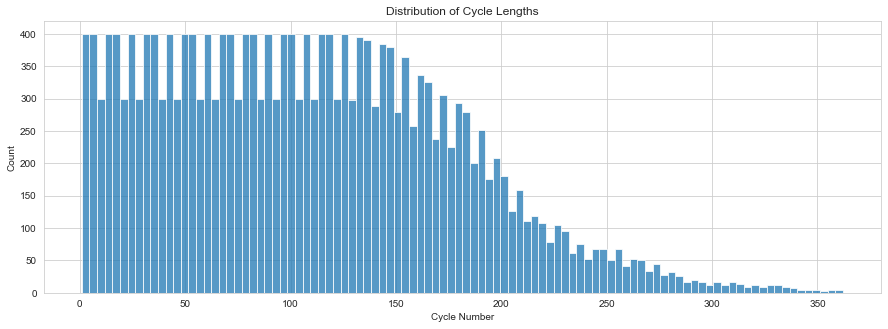

In [3]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of cycle lengths for each engine
plt.figure(figsize=(15, 5))
sns.histplot(train_data['cycle'], bins=100, kde=False)
plt.title('Distribution of Cycle Lengths')
plt.xlabel('Cycle Number')
plt.ylabel('Count')
plt.show()

**Distribution of Cycle Lengths:** The histogram of cycle lengths shows a wide range of values, suggesting that some engines have a longer lifespan than others before requiring maintenance or failure. 
- Most cycles end before reaching 200 cycles, with a long tail extending to over 350 cycles. 
- This variation in cycle length  indicate differing operating conditions or manufacturing differences among engines, i.e., changing operator/holders, testing, etc.

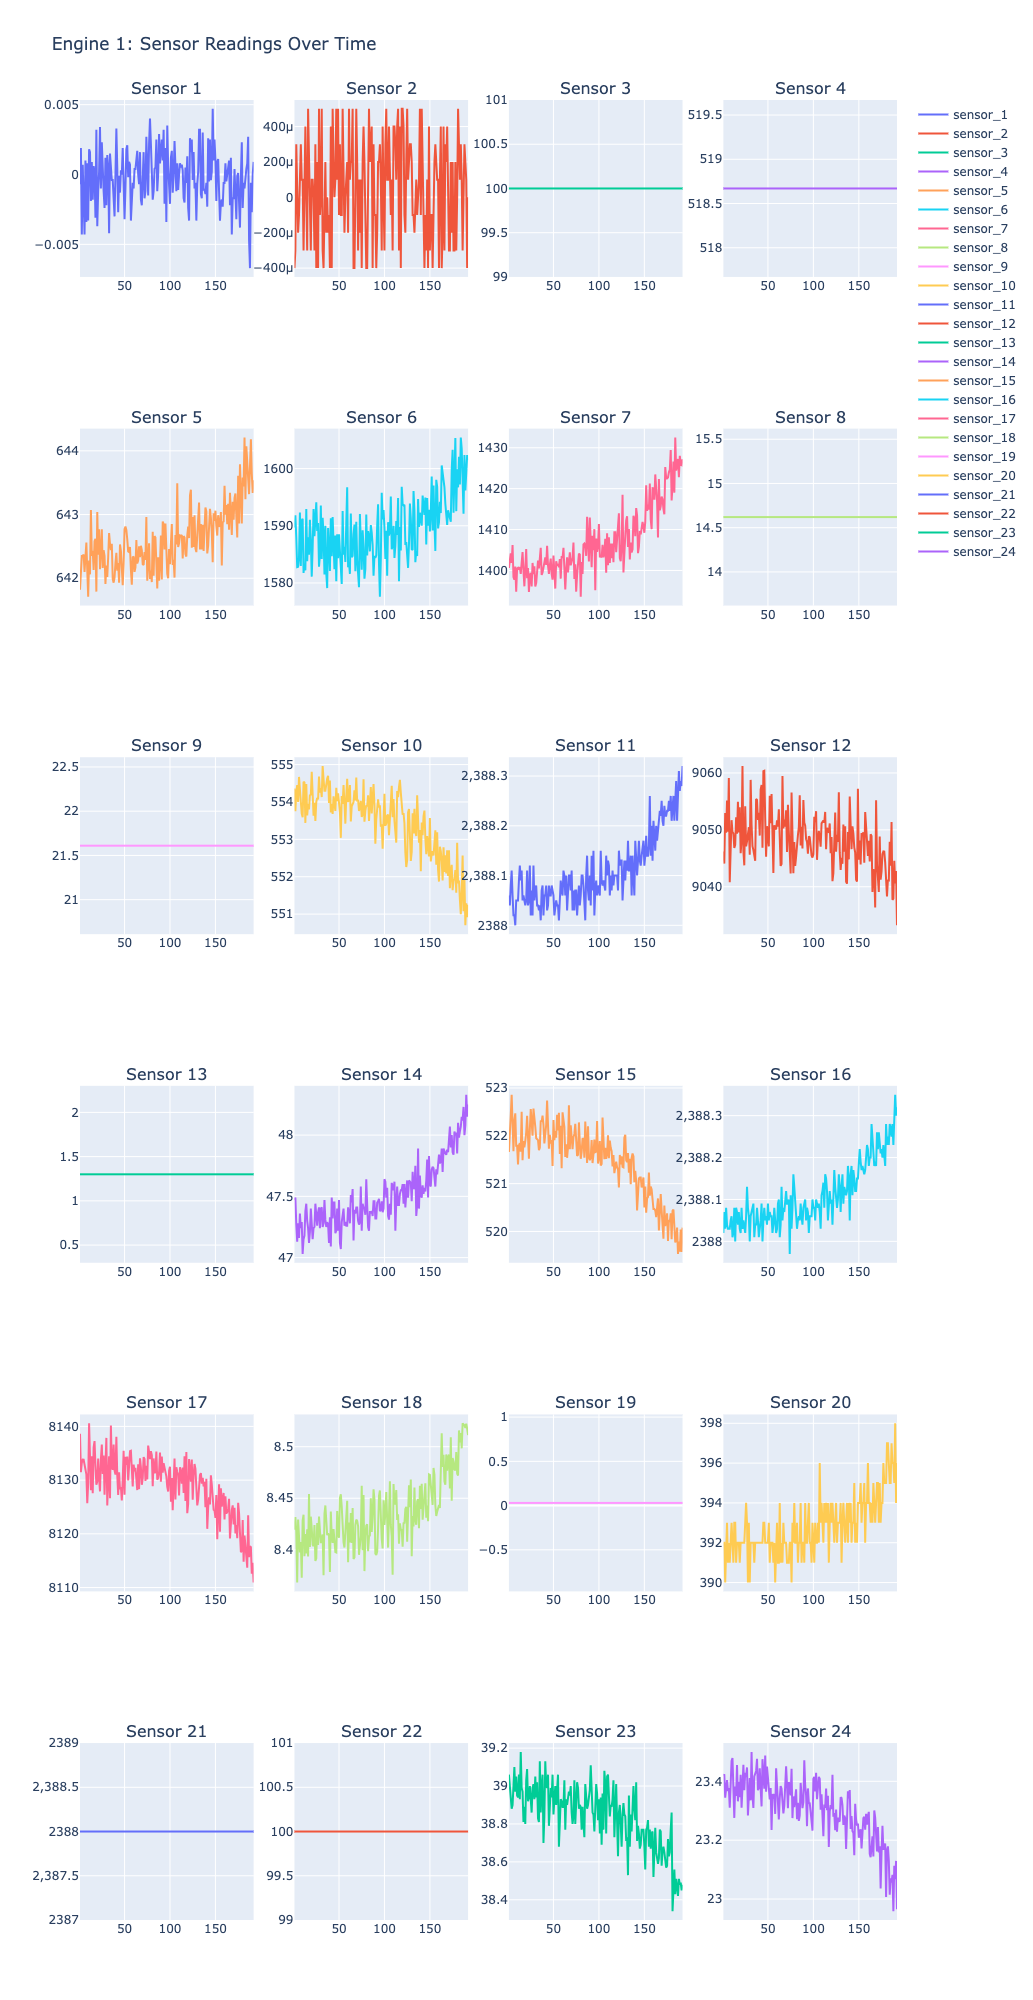

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming train_data is already loaded and processed as per previous steps

# Select a single engine for demonstration
engine_id = 1
engine_data = train_data[train_data['engine_id'] == engine_id]

# Create subplots: one for each sensor
num_sensors = 24  # Assuming we have 24 sensors
num_columns = 4  # Number of columns in the subplot grid
num_rows = num_sensors // num_columns

fig = make_subplots(rows=num_rows, cols=num_columns, subplot_titles=[f'Sensor {i+1}' for i in range(num_sensors)])

# Add a line plot for each sensor
for i in range(num_sensors):
    row = i // num_columns + 1
    col = i % num_columns + 1
    sensor_name = f'sensor_{i+1}'
    fig.add_trace(
        go.Scatter(x=engine_data['cycle'], y=engine_data[sensor_name], name=sensor_name),
        row=row, col=col
    )

# Update layout
fig.update_layout(height=2000, width=1000, title_text=f'Engine {engine_id}: Sensor Readings Over Time')
fig.update_yaxes(fixedrange=False)  # Allow y-axis to be resizable

# Show the figure
fig.show()

#### Insights

**Variability Across Engines:** There is variability in sensor readings across different engines, even for the same sensor. This could be due to different operating conditions, usage patterns, or inherent differences between engines.

**Sensor Behavior:** The behavior of each sensor can be quite different. Some sensors may show a lot of noise (frequent up and down fluctuations), while others may have a smoother trend.

**Early Warning Signs:** Some sensors may provide signs of a potential failure, evident in changes in their readings that precede a failure. This would be valuable for predictive maintenance.

**Operational Baselines:** It is possible to identify a baseline of normal operation for each sensor, against which deviations can be compared to detect anomalies. This is valuable to adjust maintenance tailored for each operators needs, and sustainment efforts to maintain servicability of hardware.

### Generate Correlation Matrix

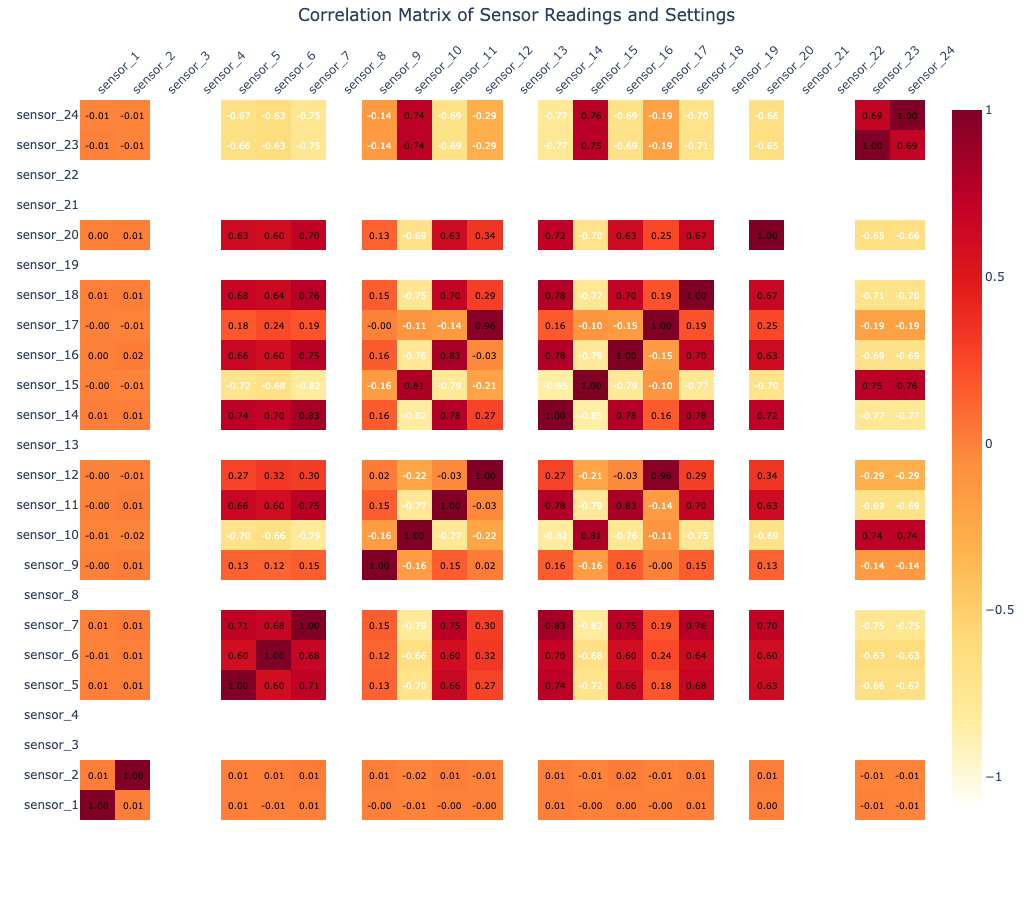

In [33]:
import plotly.figure_factory as ff
import numpy as np

# Assuming train_data is already loaded and processed as per previous steps

# Calculate the correlation matrix excluding 'engine_id' and 'cycle' columns
correlation_matrix = train_data.iloc[:, 2:].corr()

# Replace NaN values with a number that is out of the correlation range for plotting
correlation_matrix_clean = correlation_matrix.fillna(-1.1)  # Use -1.1 as it is out of the -1 to 1 range

# Create the text for annotations, rounding to two decimal places and replacing NaNs with empty strings
annotated_text = [[f"{value:.2f}" if not np.isnan(value) else '' for value in row] for row in correlation_matrix.values]

# Create the heatmap with annotations
fig = ff.create_annotated_heatmap(
    z=correlation_matrix_clean.to_numpy(),
    x=list(correlation_matrix_clean.columns),
    y=list(correlation_matrix_clean.index),
    annotation_text=annotated_text,
    showscale=True,
    colorscale='thermal'  # Using a thermal color scale
)

# Define the color for NaNs and the color scale
colors = ['rgb(255,255,255)', 'rgb(255,237,160)', 'rgb(254,217,118)',
          'rgb(254,178,76)', 'rgb(253,141,60)', 'rgb(252,78,42)',
          'rgb(227,26,28)', 'rgb(189,0,38)', 'rgb(128,0,38)']
scale = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

fig.data[0].colorscale = list(zip(scale, colors))

# Update the layout to adjust the font size of annotations and improve the title positioning
fig.update_layout(
    title={
        'text': 'Correlation Matrix of Sensor Readings and Settings',
        'y':0.99,  # Adjust the title position upwards
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1000,
    height=900,
    xaxis=dict(tickangle=-45),
    yaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix_clean.index))), ticktext=list(correlation_matrix_clean.index)),
    plot_bgcolor='white',  # Set background to white
    paper_bgcolor='white'
)

# Update the annotations to adjust the font size
for annotation in fig.layout.annotations:
    annotation.font.size = 9  # Adjust font size here

# Show the figure
fig.show()

#### Correlation Matrix of Sensor Readings and Settings
The heatmap of the correlation matrix indicates some sensors are highly correlated with each other, which could be due to underlying physical relationships or redundancies in what is being measured. Strongly correlated sensors may provide overlapping information and could be candidates for dimensionality reduction techniques.

## EDA/Conclusion

#### The engines in our dataset show a wide variation in operational life before maintenance, with most engines requiring attention before 200 cycles.

#### Sensor trends for individual engines may hold clues about impending maintenance needs. SME interpretation may provide better insight regarding failure modes from these patterns.

#### Some sensors appear to be highly correlated, suggesting an opportunity to streamline our predictive modeling by focusing on a subset of the most informative readings.

# Run LSTM Model

In [34]:
import keras
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

### (Re)Import Test/Train/Truth Datasets

The training data consists of multiple multivariate time series with "cycle" as the unit of time, with 21 sensor readings for each cycle, i.e. s1-s21 columns. Each time series can be assume as being generated from a different engine of the same type. The test data has the same schema, with difference that the data does not indicate when the failure occurs. The ground truth data provides the number of remaining working cycles for the engines in the testing data.

In [35]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [36]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [37]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [38]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Data Preprocessing
Generaing labels for training data for remaining life (RUI), label1 and label2. The binary classification will make use of label1 only, in attempt to answer the initial question of whether a specific engine will fail within w1 cycles.

In [40]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [41]:
# generate label columns for training data
w1 = 15
w0 = 5
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [42]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Preparing the test data will involve normalizing it using the parameters from the min-max normalization applied on the training data.

In [43]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Next, the ground truth dataset is used to generate labels for the test data

In [44]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [45]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142.0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141.0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140.0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139.0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138.0


In [46]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142.0,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141.0,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140.0,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139.0,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138.0,0,0


## Modelling: Longer Maintenance Windows

The benefit of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering. 
- The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. 
- The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

In [47]:
# pick a large window size of 50 cycles
sequence_length = 50

In [49]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

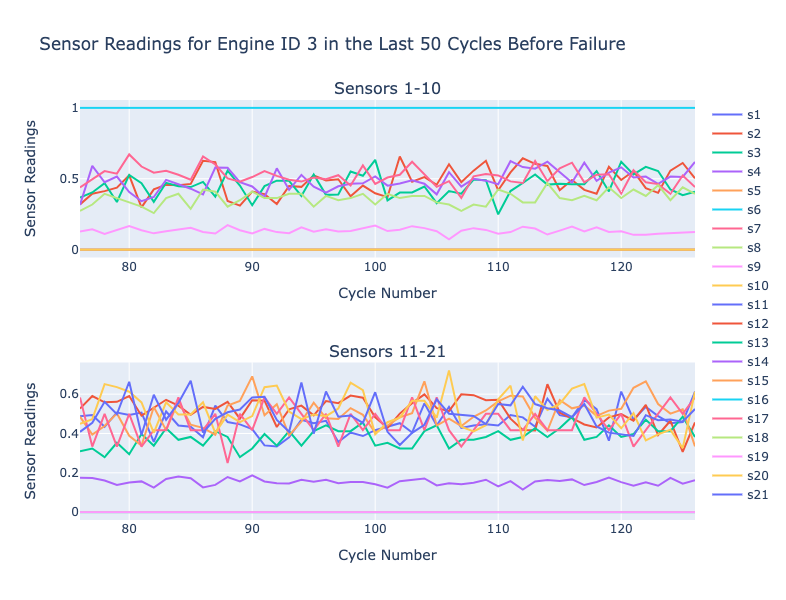

In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming engine_id3_50cycleWindow1 and engine_id3_50cycleWindow2 are already defined

# Create subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=('Sensors 1-10', 'Sensors 11-21'))

# Plot for sensors 1-10
for col in cols1:
    fig.add_trace(
        go.Scatter(x=engine_id3_50cycleWindow['cycle'], y=engine_id3_50cycleWindow1[col], mode='lines', name=col),
        row=1, col=1
    )

# Plot for sensors 11-21
for col in cols2:
    fig.add_trace(
        go.Scatter(x=engine_id3_50cycleWindow['cycle'], y=engine_id3_50cycleWindow2[col], mode='lines', name=col),
        row=2, col=1
    )

# Update xaxis properties
fig.update_xaxes(title_text="Cycle Number", row=1, col=1)
fig.update_xaxes(title_text="Cycle Number", row=2, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Sensor Readings", row=1, col=1)
fig.update_yaxes(title_text="Sensor Readings", row=2, col=1)

# Update title and layout
fig.update_layout(height=600, width=800, title_text="Sensor Readings for Engine ID 3 in the Last 50 Cycles Before Failure")

# Show figure
fig.show()

Note: Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

In [53]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [54]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [55]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [56]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [57]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [58]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM Network (Long Short Term Memory)
This section will build the deep learning network. The first layer is a long short term memory later with 100 units followed by another LSTM layer with 50 units. We apply dropout after each LSTM layer to control overfitting. The final layer is a dense output layer with single unit and sigmoid activation, due to this being a binary classiification problem (failure: yes/no)

In [59]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
import time
epochs = 8
batch_size = 200
start = time.time()

# Fit the network
history = model.fit(seq_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/8
75/75 - 17s - loss: 0.2294 - accuracy: 0.9132 - val_loss: 0.0953 - val_accuracy: 0.9655 - 17s/epoch - 230ms/step
Epoch 2/8
75/75 - 14s - loss: 0.0771 - accuracy: 0.9701 - val_loss: 0.0531 - val_accuracy: 0.9757 - 14s/epoch - 190ms/step
Epoch 3/8
75/75 - 15s - loss: 0.0553 - accuracy: 0.9787 - val_loss: 0.0667 - val_accuracy: 0.9719 - 15s/epoch - 204ms/step
Epoch 4/8
75/75 - 15s - loss: 0.0437 - accuracy: 0.9832 - val_loss: 0.0820 - val_accuracy: 0.9680 - 15s/epoch - 197ms/step
Epoch 5/8
75/75 - 15s - loss: 0.0485 - accuracy: 0.9791 - val_loss: 0.0468 - val_accuracy: 0.9783 - 15s/epoch - 206ms/step
Epoch 6/8
75/75 - 14s - loss: 0.0389 - accuracy: 0.9830 - val_loss: 0.0544 - val_accuracy: 0.9706 - 14s/epoch - 184ms/step
Epoch 7/8
75/75 - 14s - loss: 0.0386 - accuracy: 0.9840 - val_loss: 0.0423 - val_accuracy: 0.9847 - 14s/epoch - 186ms/step
Epoch 8/8
75/75 - 14s - loss: 0.0353 - accuracy: 0.9855 - val_loss: 0.0964 - val_accuracy: 0.9629 - 14s/epoch - 190ms/step
Total time taken

## Model Performance Metrics

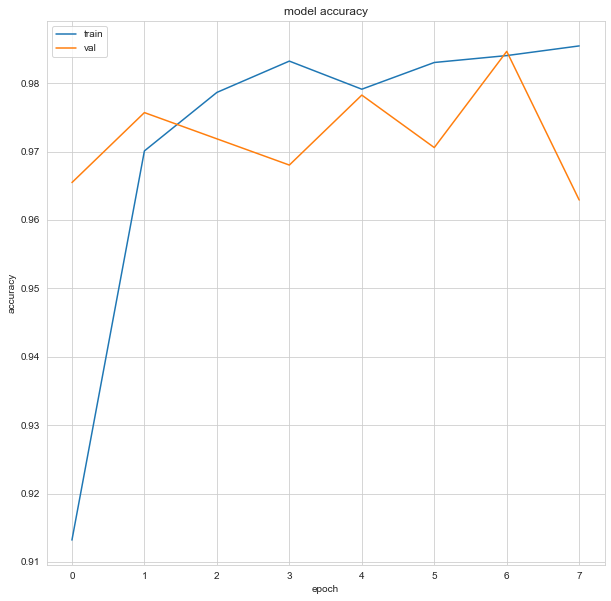

In [62]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 5s 68ms/step - loss: 0.0700 - accuracy: 0.9686
Accurracy: 0.9685880541801453


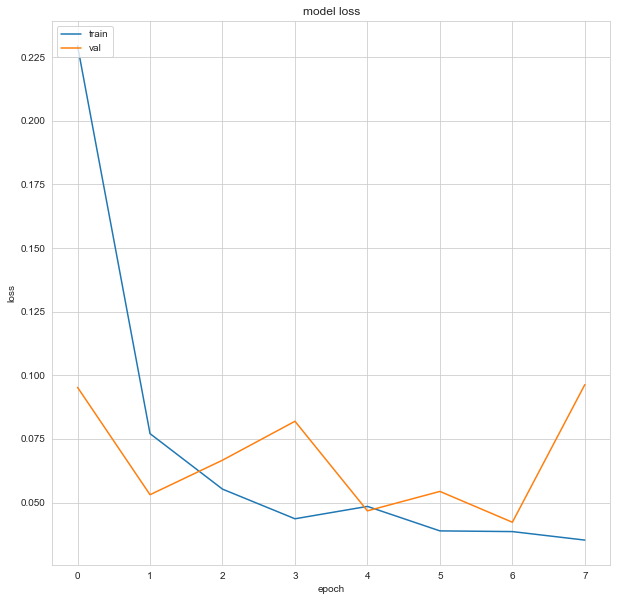

In [64]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
# Training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_array, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 [==============================] - 7s 23ms/step - loss: 0.0700 - accuracy: 0.9686
Train Accurracy: 0.9685880541801453
79/79 [==============================] - 6s 67ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[14031     0]
 [  491  1109]]
Train Precision =  1.0 
 Train Recall =  0.693125


In [66]:
# Define a threshold (e.g., 0.5)
threshold = 0.5

# Convert continuous predictions to binary using the threshold
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

# Compute precision and recall
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1_test = 2 * (precision * recall) / (precision + recall)

print('precision =', precision)
print('recall =', recall)
print('F1-Score =', f1_test)

precision = 1.0
recall = 0.693125
F1-Score = 0.8187523071244002


## Model Summary
Comparing the above test results to the predictive maintenance template, we see that the LSTM results are better than the template. It should be noted that the data set used here is very small and deep learning models are known to perform superior with large datasets so for a more fair comparison larger datasets should be used.